In [2]:
!python --version
!pip show torch random numpy seaborn matplotlib scikit-learn | findstr "Name Version"

Python 3.10.10
Name: torch
Version: 2.6.0
Name: numpy
Version: 2.0.2
        Name: lapack-lite
        Name: dragon4
        Name: libdivide
        Name: Meson
        Name: spin
        Name: OpenBLAS
        Name: LAPACK
        Name: GCC runtime library
        Version 3.1, 31 March 2009
                               Version 3, 29 June 2007
          5. Conveying Modified Source Versions.
          14. Revised Versions of this License.
Name: seaborn
Version: 0.13.2
Name: matplotlib
Version: 3.10.1
Name: scikit-learn
Version: 1.6.1
         Name: Microsoft Visual C++ Runtime Files


### 提示

若只想测试已有模型分类准确率，请自上而下依次运行必要的单元格（或禁用最后一个单元格（训练）后点击全部运行，其中随机展示部分由于需要遍历整个数据集统计信息，运行相对较慢）

### 加载数据集


In [7]:
import torch
import random
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
# 数据增强
class DataSetOpt:
    def __init__(self, add_gaussian_noise=True, mean=0.0, std=0.03, use_cutout=True, num_holes=1, size=4):
        # 高斯噪声
        self.add_gaussian_noise = add_gaussian_noise
        self.mean = mean
        self.std = std
        # Cutout
        self.use_cutout = use_cutout
        self.num_holes = num_holes
        self.size = size

    def __call__(self, img):
        if self.add_gaussian_noise:
            img = img + torch.randn(img.size()) * self.std + self.mean
        if self.use_cutout:
            h, w = img.size(1), img.size(2)
            for _ in range(self.num_holes):
                y = random.randint(0, h)
                x = random.randint(0, w)
                img[
                    :,
                    max(0, y - self.size // 2) : min(h, y + self.size // 2),
                    max(0, x - self.size // 2) : min(w, x + self.size // 2),
                ] = 0

        return img

In [9]:
torch.manual_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)
# 先几何变换再裁剪比较适合分类任务，不然容易丢失全局特征
# 强数据增强（前期）
# 数据增强还是不太适合乱搞，之前本来都练出82%的准确率了，乱搞一通掉到70%
strong_transforms = transforms.Compose(
    [
        AutoAugment(policy=AutoAugmentPolicy.CIFAR10),  # 包含注释掉的那些了
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        # transforms.RandomAffine(
        #    degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)
        # ),  # 平移和缩放
        # transforms.RandomCrop(24),  # 随机裁剪为 24x24
        # transforms.Resize(32),  # 恢复到 32x32，确保后面输入正常
        # transforms.ColorJitter(
        #    brightness=0.2, contrast=0.2, saturation=0.2
        # ),  # 颜色扰动
        transforms.ToTensor(),
        DataSetOpt(std=0.03, use_cutout=True),  # 高斯噪声和 Cutout
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)
# 弱数据增强（后期）
weak_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        transforms.RandomCrop(32, padding=4),  # 随机裁剪
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

# 加载完整数据集
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=strong_transforms
)
test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


# 随机抽取数据
def get_subset(dataset, ratio=1):
    indices = np.random.choice(
        len(dataset), size=int(len(dataset) * ratio), replace=False
    )
    return Subset(dataset, indices)

print("原始训练集大小：", len(train_dataset))
print("原始测试集大小：", len(test_dataset))
train_subset = get_subset(train_dataset)
test_subset = get_subset(test_dataset)
imgSize = train_subset[0][0].shape[1]
print("图像尺寸" + str(imgSize) + "x" + str(imgSize))

原始训练集大小： 50000
原始测试集大小： 10000
图像尺寸32x32


### 数据集二次划分

In [10]:
# 划分验证集
validation_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - validation_size
train_subset, validation_subset = torch.utils.data.random_split(
    train_subset, [train_size, validation_size]
)

DL_batch_size = 1024
train_loader = DataLoader(train_subset, batch_size=DL_batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_subset, batch_size=DL_batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=DL_batch_size, num_workers=2, pin_memory=True)

print(
    f"训练样本数: {len(train_subset)}, 验证样本数: {len(validation_subset)}, 测试样本数: {len(test_subset)}"
)

训练样本数: 40000, 验证样本数: 10000, 测试样本数: 10000


### 随机展示

五张图及其经过数据增强后的样子，方便调整数据增强措施

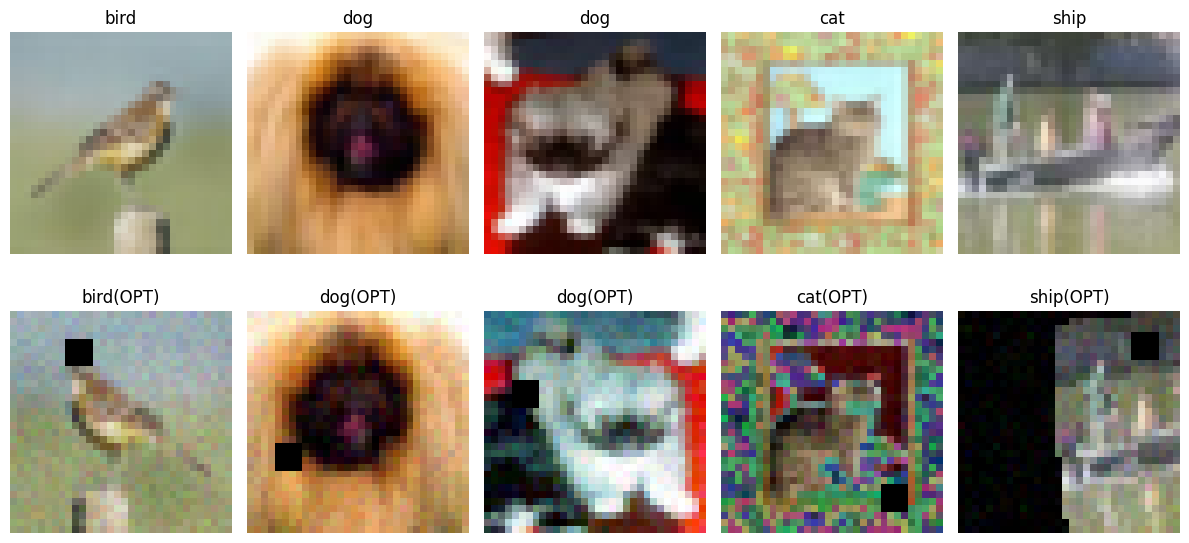

训练集统计信息:
数据集大小: 50000
通道数: 3，图像尺寸: 32x32
类别分布:
    plane: 5000 张
    car: 5000 张
    bird: 5000 张
    cat: 5000 张
    deer: 5000 张
    dog: 5000 张
    frog: 5000 张
    horse: 5000 张
    ship: 5000 张
    truck: 5000 张
每通道均值: [-0.192211   -0.17834751 -0.12485716]
每通道标准差: [1.2077042 1.2133846 1.1511583]
像素值范围: -2.6582560539245605 ~ 2.730001449584961

测试集统计信息:
数据集大小: 10000
通道数: 3，图像尺寸: 32x32
类别分布:
    plane: 1000 张
    car: 1000 张
    bird: 1000 张
    cat: 1000 张
    deer: 1000 张
    dog: 1000 张
    frog: 1000 张
    horse: 1000 张
    ship: 1000 张
    truck: 1000 张
每通道均值: [0.01139386 0.01203861 0.0149431 ]
每通道标准差: [0.9985933  0.99750423 0.999971  ]
像素值范围: -1.9894737005233765 ~ 2.12648868560791


In [6]:
cifar10_classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# 随机选择 5 张图像
show_size = 5
show_imgs = random.sample(range(len(train_dataset)), show_size)

_, axes = plt.subplots(2, show_size, figsize=(12, 6))

for i, idx in enumerate(show_imgs):
    # 数据增强后的图需要变换回来才能正常显示
    opt_img, _ = train_dataset[idx]
    opt_img = opt_img.numpy().transpose((1, 2, 0))

    # 反归一化（不然颜色会变得非常奇怪非常深，第一次跑的时候还以为我的数据增强出了什么问题）
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    opt_img = std * opt_img + mean
    opt_img = np.clip(opt_img, 0, 1)

    axes[0, i].imshow(train_dataset.data[idx])
    axes[0, i].set_title(f"{cifar10_classes[train_dataset.targets[idx]]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(opt_img)
    axes[1, i].set_title(f"{cifar10_classes[train_dataset.targets[idx]]}(OPT)")
    axes[1, i].axis("off")


def dataset_info(dataset):
    print(f"数据集大小: {len(dataset)}")

    # 获取图像形状
    img_shape = dataset[0][0].shape
    print(f"通道数: {img_shape[0]}，图像尺寸: {img_shape[1]}x{img_shape[2]}")

    # 提取所有标签
    labels = [dataset[i][1] for i in range(len(dataset))]
    labels, counts = np.unique(labels, return_counts=True)  # 统计每个类别的数量

    print("类别分布:")
    for label, cnt in zip(labels, counts):
        print(f"    {cifar10_classes[label]}: {cnt} 张")

    forAll = torch.stack(
        [dataset[i][0] for i in range(len(dataset))]
    )  # 将所有图像堆叠为一个张量
    forAll = forAll.view(-1, img_shape[0], img_shape[1] * img_shape[2])  # 展平

    print(f"每通道均值: {forAll.mean(dim=(0, 2)).numpy()}")
    print(f"每通道标准差: {forAll.std(dim=(0, 2)).numpy()}")
    print(f"像素值范围: {forAll.min().item()} ~ {forAll.max().item()}")


plt.tight_layout()
plt.show()

print("训练集统计信息:")
dataset_info(train_dataset)

print("\n测试集统计信息:")
dataset_info(test_dataset)

### 模型搭建

最大池化适合提取显著特征，平均池化适合分割图像，所以这里选最大池化`Maxpool2d`


- 卷积部分：
  - 保留原先的三组结构，每组内使用两组卷积层（包含各自的`BatchNorm`和`ReLU`），最后的输出依然经过最大池化
  - 各组内的第二个卷积层保持输入维度与输出维度等同（即继续提取更多内容，同时保持计算效率和稳定性）
  - 第一组的输出维度扩大到`128`，后续各组的输入与输出依然保持一倍的增幅
  - 其余参数不变
    - 对`CIFAR-10`任务，似乎设置`kernel_size`为`3x3`比较好
- 全连接部分：
  - 新增一个全连接层，每个全连接层之间新增一个`BatchNorm`，不过`Dropout`只需要一层就够了（不然丢得太多影响会很大）

In [55]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32/2 , 32/2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16/2 , 16/2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8/2 , 8/2   -> 4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # 第一组卷积层
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    16x16
            # 第二组卷积层
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    8x8
            # 第三组卷积层
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### 训练、验证

sgd比较适合小数据和简单模型，adam更适合分类问题

In [6]:
class ModelTrainer:
    def __init__(self, model, train_loader, validation_loader, epochs=200, lr=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.epochs = epochs
        self.lr = lr

        self.loss_func = nn.CrossEntropyLoss()  # 交叉熵损失函数适合分类  标签平滑的效果好像不是那么好
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)  # 加上正则化前期震荡有点大，需要微调，但是现在效果已经很好了就不加了
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optim, "min", patience=5
        )
        self.max_acc = 0.0

        # 拿来画图的
        self.train_losses, self.validation_losses = [], []
        self.train_accs, self.validation_accs = [], []

    def train(self):
        for epoch in range(self.epochs):
            # 动态切换数据增强策略
            if epoch == 45:  # 换到弱增强，这时候泛化能力已经不错了，希望能多学一点
                train_dataset.transform = weak_transforms
            elif epoch == 60:   # 关闭增强
                train_dataset.transform = transform

            # 训练
            train_loss, train_acc = self.train_part()

            # 验证
            validation_loss, validation_acc = self.validation_part()

            # 调整学习率
            self.scheduler.step(validation_loss)

            # 保存最佳模型
            if validation_acc > self.max_acc:
                self.max_acc = validation_acc
                torch.save(self.model.state_dict(), "CIFAR10_CNN1.pth")

            print(f"Epoch {epoch+1}/{self.epochs}")
            print(
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | validation Loss: {validation_loss:.4f}, Acc: {validation_acc:.4f}"
            )

        return self.train_losses, self.validation_losses, self.train_accs, self.validation_accs

    def train_part(self):
        self.model.train()
        loss_sum = 0.0
        correct_cnt = 0
        total = 0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optim.zero_grad()                  # 梯度清零
            outputs = self.model(inputs)            # 调用上面搭建的前向传播
            loss = self.loss_func(outputs, labels)  # 计算损失
            loss.backward()                         # 反向传播，计算梯度
            self.optim.step()                       # 更新参数

            loss_sum += loss.item()
            total += labels.size(0)     # 加载多少算多少
            _, predicted = torch.max(outputs, 1)    # 新版torch可以直接传，不需要带.data            
            correct_cnt += (predicted == labels).sum().item()

        train_loss = loss_sum / total
        train_acc = correct_cnt / total
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        return train_loss, train_acc

    def validation_part(self):
        self.model.eval()
        validation_loss = 0.0
        correct_cnt = 0
        total = 0
        with torch.no_grad():  # 验证阶段不需要计算梯度
            for inputs, labels in self.validation_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                validation_loss += self.loss_func(outputs, labels).item()

                total += labels.size(0)
                _, predicted = torch.max(outputs, 1)            
                correct_cnt += (predicted == labels).sum().item()

        validation_loss = validation_loss / total
        validation_acc = correct_cnt / total
        self.validation_losses.append(validation_loss)
        self.validation_accs.append(validation_acc)
        return validation_loss, validation_acc

print("单元格加载成功")

单元格加载成功


### 测试

仅分类运行第一格，若需额外展示分类错误结果运行第二格

In [12]:
def evaluate_model(model, test_loader, model_path="CIFAR10_CNN1.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device)) # 在colab上拿T4练的，不加上后面那个本地跑不了
    # model = torch.load(model_path, map_location=device) # 加载更快（不需要重新实例化模型），但不太安全
    model.to(device)
    model.eval()

    test_labels = []
    test_preds = []
    with torch.no_grad():
        correct_cnt = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            _, predicted = torch.max(model(inputs), 1)
            correct_cnt += (predicted == labels).sum().item()

            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

    print(f"Test Accuracy: {correct_cnt / total:.4f}")

    # 计算每个分类的准确率
    rp = classification_report(
        test_labels,
        test_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True,
    )
    for i in range(10):
        print(f"Accuracy for class {cifar10_classes[i]}: {rp[str(i)]['precision']:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix(test_labels, test_preds),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=cifar10_classes,
        yticklabels=cifar10_classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


print("单元格加载成功")

单元格加载成功


In [13]:
# 保存预测出错图片信息
error_images = {0: [], 1: [], 2: []}  # 0: {3,5}, 1: {1,9}, 2: {2,4}
error_labels = {0: [], 1: [], 2: []}  # 真实标签
error_preds = {0: [], 1: [], 2: []}  # 预测标签

# 错误率比较高的三组
label_sets = [{3, 5}, {1, 9}, {2, 4}]

def evaluate_model(model, test_loader, model_path="CIFAR10_CNN.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))  # 在colab上拿T4练的，不加上后面那个本地跑不了
    # model = torch.load(model_path, map_location=device) # 加载更快（不需要重新实例化模型），但不太安全
    model.to(device)
    model.eval()

    test_labels = []
    test_preds = []
    with torch.no_grad():
        correct_cnt = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            _, predicted = torch.max(model(inputs), 1)
            correct_cnt += (predicted == labels).sum().item()

            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

            # 展示错误分类
            if (
                len(error_images[0]) == 3
                and len(error_images[1]) == 3
                and len(error_images[2]) == 3
            ):
                continue
            for i in range(len(labels)):
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                if true_label != pred_label:
                    for idx, label_set in enumerate(label_sets):
                        if true_label in label_set and pred_label in label_set:
                            if len(error_images[idx]) < 3:  # 展示三张
                                error_images[idx].append(inputs[i].cpu())
                                error_labels[idx].append(true_label)
                                error_preds[idx].append(pred_label)
                            else:
                                break
                if (
                    len(error_images[0]) == 3
                    and len(error_images[1]) == 3
                    and len(error_images[2]) == 3
                ):
                    break
    print(f"Test Accuracy: {correct_cnt / total:.4f}")

    # 计算每个分类的准确率
    rp = classification_report(
        test_labels,
        test_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True,
    )
    for i in range(10):
        print(f"Accuracy for class {cifar10_classes[i]}: {rp[str(i)]['precision']:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix(test_labels, test_preds),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=cifar10_classes,
        yticklabels=cifar10_classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    _, axes = plt.subplots(3, 3, figsize=(12, 8))
    for i in range(3):  # 遍历每类
        for j in range(3):  # 每类展示3张
            img = error_images[i][j].permute(1, 2, 0).numpy()
            img = std * img + mean
            img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].set_title(
                f"True: {cifar10_classes[error_labels[i][j]]}, Pred: {cifar10_classes[error_preds[i][j]]}"
            )
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

### 快速评测

Test Accuracy: 0.9069
Accuracy for class plane: 0.9248
Accuracy for class car: 0.9581
Accuracy for class bird: 0.8933
Accuracy for class cat: 0.7976
Accuracy for class deer: 0.8731
Accuracy for class dog: 0.8510
Accuracy for class frog: 0.9305
Accuracy for class horse: 0.9460
Accuracy for class ship: 0.9511
Accuracy for class truck: 0.9443


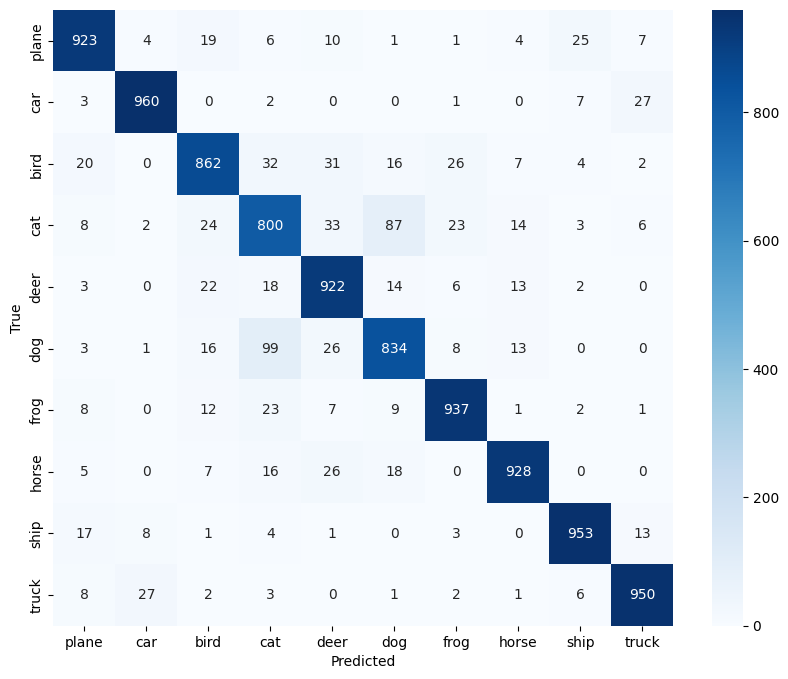

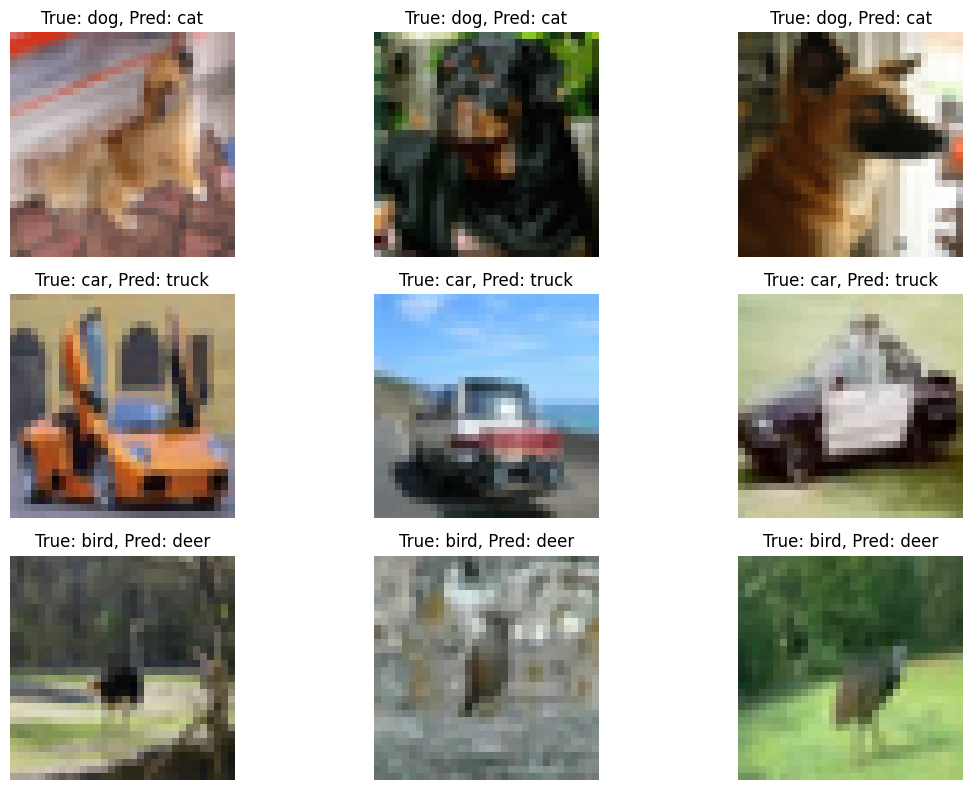

In [14]:
evaluate_model(SimpleCNN(), test_loader, "CIFAR10_CNN1.pth")

### 训练&测试

Epoch 1/70
Train Loss: 0.0023, Acc: 0.1767 | validation Loss: 0.0021, Acc: 0.2250
Epoch 2/70
Train Loss: 0.0019, Acc: 0.2862 | validation Loss: 0.0019, Acc: 0.2840
Epoch 3/70
Train Loss: 0.0017, Acc: 0.3647 | validation Loss: 0.0017, Acc: 0.3933
Epoch 4/70
Train Loss: 0.0015, Acc: 0.4335 | validation Loss: 0.0016, Acc: 0.4296
Epoch 5/70
Train Loss: 0.0014, Acc: 0.5046 | validation Loss: 0.0016, Acc: 0.4672
Epoch 6/70
Train Loss: 0.0012, Acc: 0.5547 | validation Loss: 0.0014, Acc: 0.5185
Epoch 7/70
Train Loss: 0.0011, Acc: 0.5929 | validation Loss: 0.0012, Acc: 0.5606
Epoch 8/70
Train Loss: 0.0010, Acc: 0.6304 | validation Loss: 0.0013, Acc: 0.5658
Epoch 9/70
Train Loss: 0.0009, Acc: 0.6614 | validation Loss: 0.0011, Acc: 0.6242
Epoch 10/70
Train Loss: 0.0009, Acc: 0.6766 | validation Loss: 0.0010, Acc: 0.6454
Epoch 11/70
Train Loss: 0.0009, Acc: 0.6891 | validation Loss: 0.0010, Acc: 0.6565
Epoch 12/70
Train Loss: 0.0008, Acc: 0.7061 | validation Loss: 0.0010, Acc: 0.6434
Epoch 13/70
T

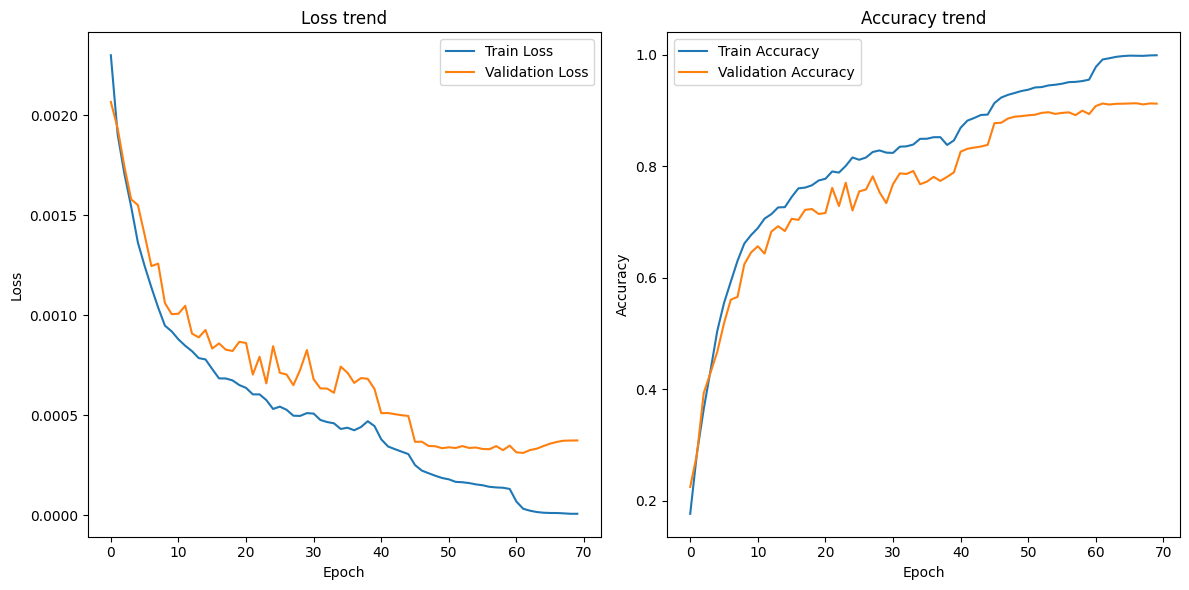

Test Accuracy: 0.9069
Accuracy for class 0: 0.9248
Accuracy for class 1: 0.9581
Accuracy for class 2: 0.8933
Accuracy for class 3: 0.7976
Accuracy for class 4: 0.8731
Accuracy for class 5: 0.8510
Accuracy for class 6: 0.9305
Accuracy for class 7: 0.9460
Accuracy for class 8: 0.9511
Accuracy for class 9: 0.9443


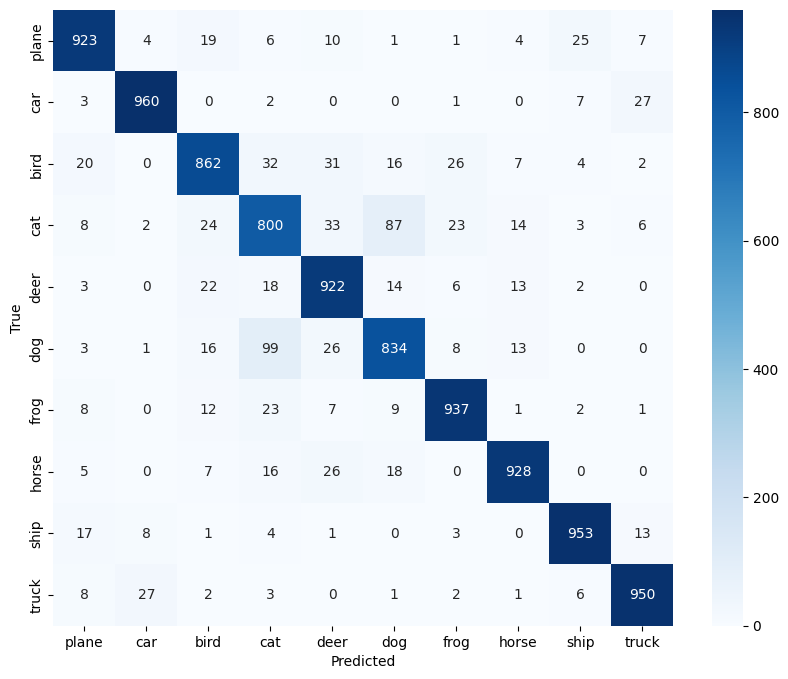

In [61]:
model = SimpleCNN()
train_losses, validation_losses, train_accs, validation_accs = ModelTrainer(
    model, train_loader, validation_loader, epochs=70, lr=0.03
).train()

# 训练/验证损失
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss trend")
plt.legend()

# 训练/验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(validation_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy trend")
plt.legend()

plt.tight_layout()
plt.show()

evaluate_model(model, test_loader)